In [1]:
#Transfer leraning with Tensorfow part 3 : Scaling up
!nvidia-smi

Fri Feb  2 19:07:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              17W /  80W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
# creating helper functions
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys

In [3]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
#Setup Data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_SIZE,shuffle=False) # dont shuffle test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
#create checkpoint callback
checkpoint_path = "transfer_learning/101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,)

In [10]:
#create data augmentation layer to incorporate it into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) #Rescale input of images between 0 & 1 , required for model like resnet50
] ,name = "data_augmentation")

In [11]:
# setup the base model and freeze its layers
#005 Creating a headless EfficientNetB0 model with data augmentation built in
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Setup model architecuture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x= data_augmentation(inputs) #augment images (only happens during training phase
x = base_model(x,training=False) # put the base model in inference mode so weights are frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # in case of models (like sequential) input go inside model in layers inputs go outside model
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [12]:
# get summary of model created
model.summary() # transfer learning feature extraction model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [14]:
#006 Fitting and evaluating our biggest transfer learning model yet
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 70s 242ms/step - loss: 3.3926 - accuracy: 0.2722 - val_loss: 2.5474 - val_accuracy: 0.4139
Epoch 2/5
237/237 [==============================] - 57s 238ms/step - loss: 2.2025 - accuracy: 0.4991 - val_loss: 2.0593 - val_accuracy: 0.5040
Epoch 3/5
237/237 [==============================] - 57s 239ms/step - loss: 1.8120 - accuracy: 0.5646 - val_loss: 1.8720 - val_accuracy: 0.5217
Epoch 4/5
237/237 [==============================] - 57s 239ms/step - loss: 1.6024 - accuracy: 0.6156 - val_loss: 1.7936 - val_accuracy: 0.5363
Epoch 5/5
237/237 [==============================] - 57s 242ms/step - loss: 1.4471 - accuracy: 0.6442 - val_loss: 1.7538 - val_accuracy: 0.5392


In [16]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 60s 76ms/step - loss: 1.6002 - accuracy: 0.5765


[1.6001890897750854, 0.5765148401260376]

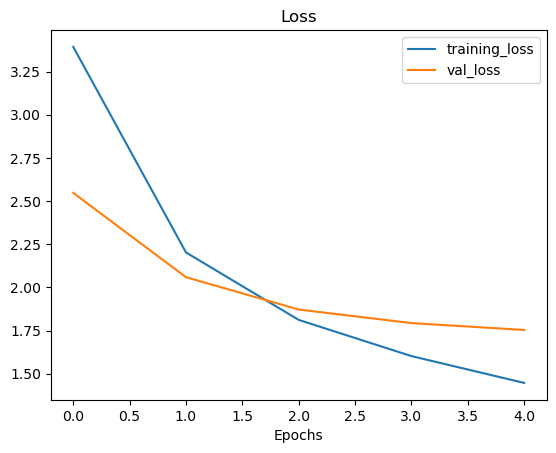

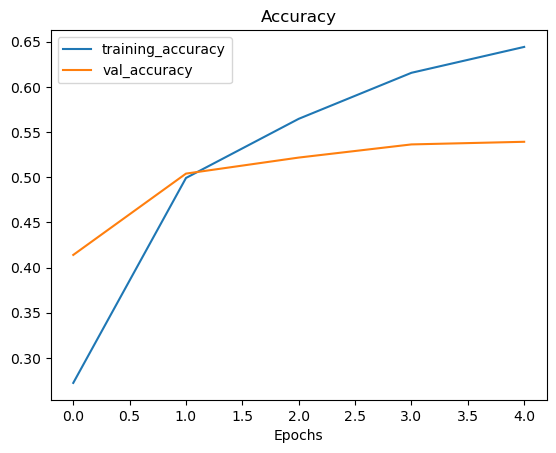

In [15]:
plot_loss_curves(history_all_classes_10_percent)

In [17]:
#007 Unfreezing some layers in our base model to prepare for fine-tuning
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last file
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [21]:
#008 Fine-tuning our feature extraction model and evaluating its performance
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 64s 241ms/step - loss: 1.2218 - accuracy: 0.6795 - val_loss: 1.7260 - val_accuracy: 0.5429
Epoch 6/10
237/237 [==============================] - 56s 238ms/step - loss: 1.0957 - accuracy: 0.7090 - val_loss: 1.7744 - val_accuracy: 0.5342
Epoch 7/10
237/237 [==============================] - 56s 237ms/step - loss: 1.0240 - accuracy: 0.7271 - val_loss: 1.7256 - val_accuracy: 0.5458
Epoch 8/10
237/237 [==============================] - 56s 238ms/step - loss: 0.9463 - accuracy: 0.7484 - val_loss: 1.7205 - val_accuracy: 0.5479
Epoch 9/10
237/237 [==============================] - 57s 241ms/step - loss: 0.8873 - accuracy: 0.7628 - val_loss: 1.7303 - val_accuracy: 0.5458
Epoch 10/10
237/237 [==============================] - 57s 240ms/step - loss: 0.8371 - accuracy: 0.7728 - val_loss: 1.7687 - val_accuracy: 0.5384


In [22]:
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 60s 76ms/step - loss: 1.5240 - accuracy: 0.5964


[1.5239622592926025, 0.5963960289955139]

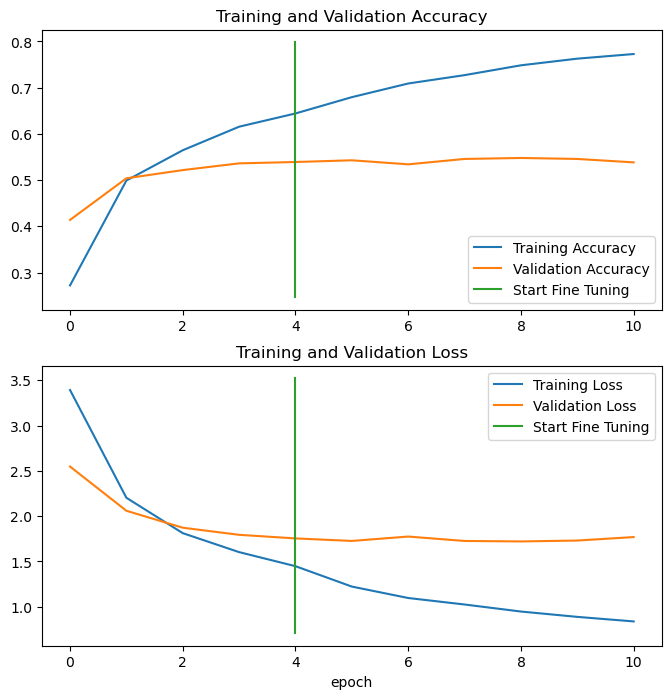

In [25]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)